In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy.stats as stats

# define cmaps for viruses
hsv1_palette = sns.light_palette((168/256, 97/256, 92/256), reverse=True, as_cmap=True)
hcmv_palette = sns.light_palette((71/256, 103/256, 133/256), reverse=True, as_cmap=True)
kshv_palette = sns.light_palette((113/256, 175/256, 71/256), reverse=True, as_cmap=True)

div_cmap = sns.blend_palette([hcmv_palette(0), '#FFFFFF', hsv1_palette(0)], as_cmap=True)

pal = ['#894e49', '#44546a', '#4a763e', '#696969'] # dark palette
pal = ['#af6e69', '#50627c', '#588c4a', '#5c5c5c'] # light palette
sns.set_palette(pal)
sns.set_context('paper')

bright_pal = [pal[0]]+['#3b5f91']+pal[2:]

# Load Data

In [2]:
def load_herpesvirusPRMreport(
    file, 
    virus, 
    n_points = 8, 
    ignore_peptide_note = ['Do not quant', 'do not quant'], 
    replicate_fmt = 'treatment_timepoint_replicate', 
    index_cols = ['Protein Gene', 'Protein Accession', 'temporality', 'Peptide Modified Sequence', 'treatment', 'timepoint', 'replicate', 'File Name'],
    data_cols = ['Total Area Fragment'],
):

    df = pd.read_csv(file)
    
    df['Peptide Retention Time'] = df['Peptide Retention Time'].where(df['Peptide Retention Time'].notnull(), df['Predicted Result Retention Time'])
    df['Total Area Fragment'] = df['Total Area Fragment'].where(df['Points Across Peak']>=n_points, np.nan)    
    df['Total Area Fragment'] = df['Total Area Fragment'].where(~df['Peptide Note'].isin(ignore_peptide_note), np.nan)
    df['Protein Gene'] = df['Protein Gene'].fillna(df['Protein Name'])

    temporality = tableS1.loc[virus].set_index('accession')['temporal class']
    df['temporality'] = temporality.reindex(df['Protein Accession']).values
    df['temporality'] = df['temporality'].fillna('unknown')
    
    temp = df['Replicate'].str.split('_', expand = True)
    temp.columns = replicate_fmt.split('_')
    
    df = pd.concat([df, temp], axis=1)
    
    try:
        df['timepoint'] = df['timepoint'].str.replace('hpi', '', case=False).str.replace('mock', '0', case=False).fillna('1000000').astype(int)
    except:
        pass
    
    df = df[~df.duplicated()]
    df = df.set_index(index_cols)[data_cols]
    df = df[~df.isnull().all(axis=1)]
    
    if df.index.duplicated().any():
        print('Duplicate entries detected, dropping duplicates')
        return df.reset_index().drop_duplicates().set_index(df.index.names).squeeze()
    else:
        return df
    
def mean_normalize(df):
    return df.apply(lambda x: x/df.mean(axis=1))

def compute_CV(df):
    return df.std(axis=1)/df.mean(axis=1)

def TTEST(data):
    x1 = data.columns[0]
    x2s = data.columns[1:]
    
    res = pd.Series({x2: stats.ttest_ind(data[x1], data[x2], nan_policy='omit')[1] for x2 in x2s})
    res.name = 'p-value'
    res.index.name = 'HPI'
    
    return res

def add_stars(x):
    y = x.copy()
    y = x.where(x<0.05, '').where(x>0.05, '*').where(x>0.01, '**').where(x>0.001, '***').where(x>0.0001, '****')
    
    return y

def poisson(MOI):
    uninf = np.exp(-MOI)
    single = np.exp(-MOI)*MOI
    multiple = 1-np.exp(-MOI)*(MOI+1)
    
    return single+multiple

In [3]:
tableS1 = pd.concat({v:pd.read_csv(r'..\tables\TableS1{}.csv'.format(l)) for l, v in zip(['A', 'B', 'C'], ['HSV-1','HCMV','KSHV'])}, names = ['virus'])

components = tableS1.reset_index()[['accession', 'virion classification*']].set_index('accession').squeeze()
temporality = tableS1.reset_index()[['accession', 'temporal class']].set_index('accession').squeeze()
components = components[~components.index.duplicated()]
temporality = temporality[~temporality.index.duplicated()]

In [4]:
folder = r'..\Skyline_reports'
filename = 'HCMV_MOIs.csv'

MOI = load_herpesvirusPRMreport(os.path.join(folder, filename), 'HCMV', replicate_fmt = 'timepoint_treatment_replicate')
filename_mapping = MOI.reset_index()[['treatment', 'timepoint', 'replicate', 'File Name']].drop_duplicates().set_index('File Name')

Duplicate entries detected, dropping duplicates


In [5]:
fl = load_herpesvirusPRMreport(os.path.join(r'..\Skyline_reports', 'HSV-1_frontal_lobe.csv'), 'HSV-1', n_points=1)
fl_detected_peptides = fl.groupby(['temporality', 'treatment', 'Protein Gene', 'Protein Accession', 'Peptide Modified Sequence']).size().groupby(['temporality', 'treatment', 'Protein Gene', 'Protein Accession', ]).size().unstack(1)
fl_detected_peptides['component'] = components.reindex(fl_detected_peptides.index, level='Protein Accession')
fl_detected_peptides = fl_detected_peptides.reset_index().set_index(fl_detected_peptides.index.names+['component'])

a = fl_detected_peptides['frontal lobe'].dropna().groupby(['Protein Gene', 'temporality']).size().groupby('temporality').size()/59
a = pd.concat([a, tableS1.loc['HSV-1'].groupby(['gene name', 'temporal class']).size().groupby('temporal class').size()/59-a], keys = ['found', 'missing'], names = ['level']).dropna()
a.index.names = ['level', 'temporality']

b = fl_detected_peptides['frontal lobe'].dropna().groupby(['Protein Gene', 'component']).size().groupby('component').size()/59
b = pd.concat([b, tableS1.loc['HSV-1'].groupby(['gene name', 'virion classification*']).size().groupby('virion classification*').size()/59-b], keys = ['found', 'missing'], names = ['level']).dropna()
b.index.names = ['level', 'component']

Duplicate entries detected, dropping duplicates


# Normalize Data

### MS1 normalization

In [7]:
filename = r'..\MS1_intensities_RawMeat.csv'

MS1 = pd.read_csv(filename, index_col=[0]).squeeze()
MS1.index = MS1.index+'.raw'
MS1 = pd.concat([MS1[MS1.index.isin(MOI.index.get_level_values('File Name').unique())], filename_mapping], axis=1).reset_index().set_index(['treatment', 'timepoint', 'replicate', 'File Name']).squeeze()
ratios = MS1.groupby(['replicate']).apply(lambda x: x/x.mean())

MOI_adj = MOI.groupby(ratios.index.names).apply(lambda x: x/ratios[x.name]).unstack('File Name').mean(axis=1)

### Mean normalization

In [8]:
cols = ['treatment', 'timepoint']
MOI_norm = mean_normalize(MOI_adj.unstack(cols)).stack(cols)
idx = MOI_norm.index.names
MOI_norm = MOI_norm.reset_index()
MOI_norm['replicate'] = MOI_norm['replicate'].where(MOI_norm['treatment']!='0.05-1', 'R1')
MOI_norm['treatment'] = MOI_norm['treatment'].where(MOI_norm['treatment']!='0.05-1', '0.05').astype(float)
MOI_norm = MOI_norm.set_index(idx).squeeze()

MOI_avg = MOI_norm.unstack(['Peptide Modified Sequence']).mean(axis=1)
MOI_mean = MOI_avg.unstack('replicate').mean(axis=1)

# Export Supplemental Tables

In [11]:
temp = MOI_norm.unstack(['treatment', 'timepoint', 'replicate']).T.sort_index().T
temp.columns.names = ['MOI', 'time point (HPI)', 'replicate']
temp.to_csv(r'..\tables\TableS3A.csv')

# Make Figures

In [17]:
low_detect = MOI_norm.unstack('treatment').apply(lambda x: x.unstack('replicate').notnull().any(axis=1).unstack('Peptide Modified Sequence').sum(axis=1)).unstack('timepoint').fillna(0)
low_detect = low_detect[low_detect.index.get_level_values('temporality').isin(['IE','DE', 'LL', 'L'])].sort_index()
n_peps = MOI_norm.groupby(low_detect.index.names).apply(lambda x: x.index.get_level_values('Peptide Modified Sequence').unique().shape[0])
pct_low_detect = low_detect.apply(lambda x: x/n_peps.loc[x.index])*100

pct_low_detect = pct_low_detect.reset_index()
pct_low_detect['Protein Gene'] = [i.split('|')[-1].replace('_HCMVA', '') for i in pct_low_detect['Protein Gene']]
pct_low_detect = pct_low_detect.set_index(['Protein Gene', 'Protein Accession', 'temporality'])

low_detect = low_detect.reset_index()
low_detect['Protein Gene'] = [i.split('|')[-1].replace('_HCMVA', '') for i in low_detect['Protein Gene']]
low_detect = low_detect.set_index(['Protein Gene', 'Protein Accession', 'temporality'])

### Fig. 3A

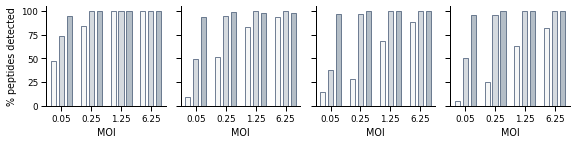

In [18]:
new_value = .17
h = 2.1

g = sns.catplot(data=(MOI_norm.unstack(['timepoint', 'treatment']).groupby(['temporality', 'Protein Gene', 'Peptide Modified Sequence']).apply(lambda x: x.notnull().any()).groupby('temporality').mean().stack([0, 1])*100).reset_index(),
            x='treatment', y=0, hue='timepoint', col='temporality', kind='bar', col_order = ['IE', 'DE', 'LL', 'L'], 
                height=h, aspect = 8.1/h/4, legend=False, saturation=.75, 
                palette = [i for i in hcmv_palette(np.linspace(0.25, 1, 3))[::-1]],
                hue_order = [24, 72, 120]
               )

for ax in g.axes.flat:
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

        r, b, g_, a = patch.get_facecolor()
        patch.set_facecolor((r, b, g_, 0.55))
        patch.set_edgecolor(pal[1])

g.set_axis_labels(x_var='MOI', y_var='% peptides detected')
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
[ax.set_title('') for ax in g.axes.flat]
g.axes.flat[0].get_figure().tight_layout()
g.axes.flat[0].get_figure().savefig(r'..\figures\Fig3A.png', dpi=1000, bbox_inches='tight')
plt.show()

### Fig. 3B (graphic made in PowerPoint)

In [28]:
print((low_detect>0).sum().swaplevel().sort_index())

timepoint  treatment
24         0.05         16
           0.25         48
           1.25         79
           6.25         86
72         0.05         59
           0.25         89
           1.25         90
           6.25         90
120        0.05         90
           0.25         90
           1.25         90
           6.25         90
dtype: int64


### Fig. 3C

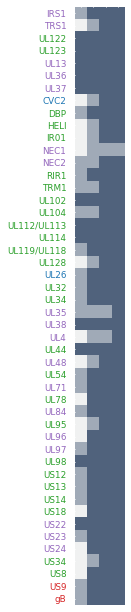

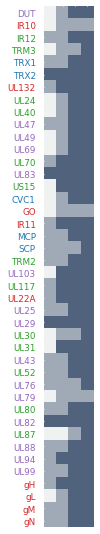

In [35]:
component_colors = dict(zip(['capsid', 'non-structural', 'envelope', 'tegument'], 
                            [sns.color_palette('tab10')[0]]+sns.color_palette('tab10')[2:5]))

ts = ['IE', 'DE', 'LL', 'L']
data = pct_low_detect.reset_index('Protein Accession', drop=True).swaplevel().sort_index()
data = pd.concat([data.loc[[t], :].sort_index() for t in ts], sort=False).T
ns = (low_detect.reset_index(['Protein Accession'], drop=True).T[data.swaplevel(axis=1).columns]>0)*1
first_timepoint = ns.where(ns!=0, np.nan).apply(lambda x: x.groupby('treatment').apply(lambda y: y.first_valid_index()[-1])).swaplevel(axis=1)

h = 8.6
r = h/max([first_timepoint[t].shape[1] for t in [['IE', 'DE'], ['LL', 'L']]])

for i, ts in enumerate([['IE', 'DE'], ['LL', 'L']]):
    
    to_plot = pd.concat([first_timepoint[t] for t in ts], sort=False, axis=1)
    
    fig, ax = plt.subplots(figsize=(8, r*to_plot.shape[1]))
    
    sns.heatmap(to_plot.T, 
                cmap = sns.light_palette(pal[1], as_cmap=True, reverse=True), 
                ax=ax, 
                cbar=False, 
                yticklabels = to_plot.columns, 
                square=True
               )

    ax.xaxis.tick_top()
    ax.set_xticklabels([])
    ax.set_ylim(to_plot.T.shape[0], 0)

    ax.set_xlabel('')
    ax.set_ylabel('')
    
    for l in ax.get_yticklabels():
        l.set_color(component_colors[tableS1.set_index('gene name')['virion classification*'][[l._text]].unique()[0]])

    plt.tick_params(color='white')
    fig.tight_layout()

    fig.savefig(r'..\figures\Fig3C_pt{}.png'.format(i+1), dpi=1000, bbox_inches='tight')
    plt.show()

### Fig. 3D

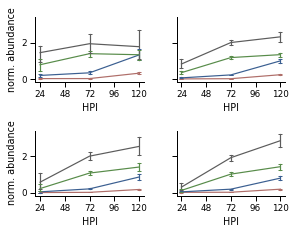

In [14]:
fig, axs =plt.subplots(figsize=(4.2, 3.2), nrows=2, ncols=2, sharey=True)

for ax, t in zip(axs.flatten(), ['IE', 'DE', 'LL', 'L']):
    to_plot = MOI_mean[MOI_mean.index.get_level_values('temporality')==t]
    
    sns.lineplot(data=to_plot.reset_index(), x='timepoint', y=0, 
                 hue='treatment', 
                 palette=bright_pal, 
                 ax=ax,
                 err_style='bars', err_kws = {'capsize': 2}
                )
    
    ax.get_legend().remove()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([24, 48, 72, 96, 120])
    
    #ax.set_yticklabels([])
    #ax.set_xticklabels([])
    ax.set_xlabel('HPI')
    ax.set_ylabel('')
    
[ax.set_ylabel('norm. abundance') for ax in axs[:, 0]] 

fig.tight_layout()

plt.subplots_adjust(hspace=.75, wspace=0.3)
fig.savefig(r'..\figures\Fig3D.png', dpi=1000, bbox_inches='tight')
plt.show()
plt.close()



### Fig. 3E

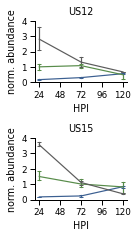

In [15]:
fig, axs =plt.subplots(figsize=(2, 3.4), nrows=2, sharey=True)

for p, ax in zip(['US12', 'US15'], axs):
    sns.lineplot(data=MOI_norm[MOI_norm.index.get_level_values('Protein Gene')==p].reset_index(), x='timepoint', y=0, 
                 hue='treatment', 
                 palette=bright_pal[1:], 
                 ax=ax,
                 hue_order = [0.25, 1.25, 6.25],
                 err_style='bars', err_kws = {'capsize': 2}
                )
    
    ax.get_legend().remove()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([24, 48, 72, 96, 120])
    ax.set_title(p)
    
    ax.set_xlabel('HPI')
    ax.set_ylabel('norm. abundance')
    ax.set_ylim(0, 4)
    ax.set_yticks(range(5))

fig.tight_layout()
fig.savefig(r'..\figures\Fig3E.png', dpi=1000, bbox_inches='tight')
plt.show()
plt.close()

### Fig. 3F

In [88]:
print('# proteins detected: {:.0f} ({:.0f}%)'.format((temp['frontal lobe']>0).sum(), (temp['frontal lobe']>0).sum()/59*100))
print('# peptides detected: {:.0f} ({:.0f}%)'.format(temp['frontal lobe'].sum(), temp['frontal lobe'].sum()/184*100))

# proteins detected: 47 (80%)
# peptides detected: 90 (49%)


### Fig. 3G (pie charts annotated in PowerPoint)

In [77]:
print((a*59))
print('=========================')
print((b*59))

level    temporality
found    E              12.0
         IE              4.0
         L              31.0
missing  E               4.0
         IE              1.0
         L               7.0
dtype: float64
level    component     
found    capsid             7.0
         envelope           8.0
         non-structural    12.0
         tegument          20.0
missing  capsid             1.0
         envelope           3.0
         non-structural     5.0
         tegument           3.0
dtype: float64


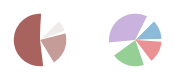

In [68]:
fig, axs = plt.subplots(figsize = (3.5, 1.2), ncols=2)

component_colors = dict(zip(['capsid', 'non-structural', 'envelope', 'tegument'], 
                            [sns.color_palette('tab10')[0]]+sns.color_palette('tab10')[2:5]))

cm = list(zip(sns.light_palette((168/256, 97/256, 92/256), as_cmap=True)([10, 150, 250]).tolist(), ['white', 'white', 'white']))
cm = [j for i in cm for j in i]
patches, text = axs[0].pie(
    a.swaplevel().sort_index()[['IE', 'E', 'L']], 
    colors = cm, 
#     labels = ['IE', '', 'E', '', 'L', ''],
    counterclock=False,
    normalize=False,
    startangle=45,
    labeldistance=0.8,
#     textprops = {'fontsize':14, 'ha': 'center', 'va': 'center'},
    radius=1
)
    
cm = list(zip([component_colors[i] for i in b.swaplevel().sort_index().iloc[::2].reset_index()['component']], ['white']*4))
cm = [j for i in cm for j in i]
patches, text = axs[1].pie(
    b.swaplevel().sort_index(), 
    colors = cm, 
#     labels = ['IE', '', 'E', '', 'L', ''],
    counterclock=False,
    normalize=False,
    startangle=45,
    labeldistance=0.8,
#     textprops = {'fontsize':14, 'ha': 'center', 'va': 'center'},
    radius=1
)

for p in patches[::2]:
    p.set_alpha(0.5)

fig.tight_layout()
plt.subplots_adjust(wspace=-0.3)
fig.savefig(r'..\figures\Fig3G.png', dpi=1000, bbox_inches='tight')
plt.show()

### Fig. S6A

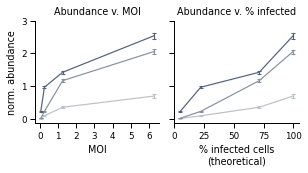

In [26]:
fig, axs = plt.subplots(ncols=2, figsize = (4.5, 2.5), sharey=True)

ax = axs[0]
data=MOI_norm.unstack('temporality')[['IE', 'DE', 'LL', 'L']].stack().reset_index()
data['treatment'] = data['treatment'].astype(float)

sns.lineplot(data=data, x='treatment', y=0, hue='timepoint', 
             palette = sns.light_palette(pal[1], n_colors=4)[1:],
             ax=ax,
             err_style='bars', err_kws = {'capsize': 2}
            )

ax.get_legend().remove()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax.set_ylim(ax.get_ylim()[0], 3)
#ax.set_yticklabels([])
#ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Abundance v. MOI')
    
ax.set_ylabel('norm. abundance')
ax.set_xlabel('MOI')

ax = axs[1]
data=MOI_norm.unstack('temporality')[['IE', 'DE', 'LL', 'L']].stack().reset_index()
data['treatment'] = data['treatment'].astype(float).map(poisson)

sns.lineplot(data=data, x='treatment', y=0, hue='timepoint', 
             palette = sns.light_palette(pal[1], n_colors=4)[1:],
             ax=ax,
             err_style='bars', err_kws = {'capsize': 2}
            )

ax.get_legend().remove()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.linspace(0, 1, 5))
ax.set_xticklabels([0, 25, 50, 75, 100])
#ax.set_yticklabels([])
#ax.set_xticklabels([])

ax.set_xlabel('')
ax.set_ylabel('norm. abundance')
ax.set_title('Abundance v. % infected')

ax.set_xlabel('% infected cells\n(theoretical)')

fig.tight_layout()
fig.savefig(r'..\figures\FigS6A.png', dpi=1000, bbox_inches='tight')
plt.show()